In [1]:
import pandas as pd
import re
import json
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

pd.options.mode.chained_assignment = None 

In [2]:
df = pd.read_csv("AN-1068-final-go.csv")

In [3]:
df.head()

,step_id,status,client,uid_anon,id_anon,reply,feedback
0,14473,1,web,99,0,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""Compilation error\n# command-line-arguments\n..."
1,14473,2,web,99,6,"{""language"": ""go"", ""code"": ""// Declare a \""che...",""""""
2,14473,2,web,53,1835,"{""language"": ""go"", ""code"": ""// Declare a \""che...",""""""
3,14474,1,web,53,1859,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Failed. Wrong answer\n"""
4,14474,1,web,53,1864,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Failed. Wrong answer\n"""


In [4]:
df.groupby('status')['id_anon'].count()

status
1    30848
2    27298
Name: id_anon, dtype: int64

In [5]:
df.groupby('client')['id_anon'].count()

client
ide          7319
idea          909
internal      842
unknown       194
web         48817
Name: id_anon, dtype: int64

In [6]:
def label(row):
    if row['status'] == 2:             
        try:
            json_data = json.loads(row['feedback'],strict=False)   
            if (len(json_data['code_style']['errors'])==0):
                return 'Correct'  
            else:
                return 'Style'
        except Exception as e:
            return "Correct, unknown style"
    else: 
        s = row['feedback']
        if s.find('Compilation error') != -1:
            return 'CE'
        if s.find('Runtime error') != -1:
            return 'RE'   
        if s.find('Time limit exceeded') != -1:
            return 'TL'
        if s.find('Perhaps') != -1:
            return 'Check error'    
        if (s.find('Failed test')) or (s.find('Wrong answer')) != -1:
            return 'WA'            
        return 'UND'

In [7]:
df['solution_label'] = df.apply (lambda row: label(row), axis=1)
df

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label
0,14473,1,web,99,0,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""Compilation error\n# command-line-arguments\n...",CE
1,14473,2,web,99,6,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""""","Correct, unknown style"
2,14473,2,web,53,1835,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""""","Correct, unknown style"
3,14474,1,web,53,1859,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Failed. Wrong answer\n""",WA
4,14474,1,web,53,1864,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Failed. Wrong answer\n""",WA
...,...,...,...,...,...,...,...,...
58141,19304,1,ide,1568,22214201,"{""choices"": null, ""score"": """", ""solution"": nul...","""Failed test #1 of 3. Wrong answer\n\nThis is ...",WA
58142,19304,1,ide,1568,22214220,"{""choices"": null, ""score"": """", ""solution"": nul...","""Failed test #1 of 3. Wrong answer\n\nThis is ...",WA
58143,19304,2,ide,1568,22214721,"{""choices"": null, ""score"": """", ""solution"": nul...","""""","Correct, unknown style"
58144,19304,2,web,578,22230880,"{""language"": ""go"", ""code"": ""package main\n\nim...","""""","Correct, unknown style"


In [9]:
df.loc[1,'reply']

'{"language": "go", "code": "// Declare a \\"chest\\" variable\\r\\nvar chest string = \\"gold\\"\\n"}'

In [8]:
df.pivot_table(values='id_anon', index = 'client', \
                     columns= 'solution_label', aggfunc= 'count', fill_value=0)

solution_label,CE,Check error,"Correct, unknown style",RE,TL,WA
client,,,,,,
ide,2403,27,3534,46,21,1288
idea,263,3,516,4,0,123
internal,99,0,728,0,0,15
unknown,2,0,166,0,0,26
web,17938,149,22291,307,55,8077


In [10]:
df.groupby('solution_label')['id_anon'].count()

solution_label
CE                        20707
Check error                 179
Correct, unknown style    27298
RE                          357
TL                           76
WA                         9529
Name: id_anon, dtype: int64

In [11]:
df_tasks = df.pivot_table(values='id_anon', index = 'step_id', \
                     columns= 'solution_label', aggfunc= 'count', fill_value=0)
df_tasks

solution_label,CE,Check error,"Correct, unknown style",RE,TL,WA
step_id,,,,,,
14473,1075,0,835,0,0,69
14474,760,0,731,0,0,365
14475,1603,0,864,0,0,10
14476,553,0,890,0,0,29
14532,249,0,885,0,1,71
...,...,...,...,...,...,...
19202,0,0,9,0,0,8
19301,8,0,10,0,0,0
19302,12,0,8,0,0,50


In [14]:
df_tasks['total'] = df_tasks['CE'] + df_tasks['Check error'] + df_tasks['Correct, unknown style'] + df_tasks['RE'] +  df_tasks['TL'] + df_tasks['WA']
df_tasks

solution_label,CE,Check error,"Correct, unknown style",RE,TL,WA,total
step_id,,,,,,,
14473,1075,0,835,0,0,69,1979
14474,760,0,731,0,0,365,1856
14475,1603,0,864,0,0,10,2477
14476,553,0,890,0,0,29,1472
14532,249,0,885,0,1,71,1206
...,...,...,...,...,...,...,...
19202,0,0,9,0,0,8,17
19301,8,0,10,0,0,0,18
19302,12,0,8,0,0,50,70


In [16]:
df_tasks['rate'] = (df_tasks['Correct, unknown style'])/df_tasks['total']
df_tasks

solution_label,CE,Check error,"Correct, unknown style",RE,TL,WA,total,rate
step_id,,,,,,,,
14473,1075,0,835,0,0,69,1979,0.421930
14474,760,0,731,0,0,365,1856,0.393858
14475,1603,0,864,0,0,10,2477,0.348809
14476,553,0,890,0,0,29,1472,0.604620
14532,249,0,885,0,1,71,1206,0.733831
...,...,...,...,...,...,...,...,...
19202,0,0,9,0,0,8,17,0.529412
19301,8,0,10,0,0,0,18,0.555556
19302,12,0,8,0,0,50,70,0.114286


In [17]:
df_tasks[(df_tasks['rate']<0.5) & (df_tasks['total']>1000)]

solution_label,CE,Check error,"Correct, unknown style",RE,TL,WA,total,rate
step_id,,,,,,,,
14473,1075,0,835,0,0,69,1979,0.421930
14474,760,0,731,0,0,365,1856,0.393858
14475,1603,0,864,0,0,10,2477,0.348809
14533,216,0,752,0,0,600,1568,0.479592
14534,474,0,703,6,0,390,1573,0.446917
14711,272,0,548,0,4,292,1116,0.491039
14713,255,0,424,1,18,549,1247,0.340016
14714,415,179,522,32,40,316,1504,0.347074
15416,202,0,547,0,0,509,1258,0.434817


In [18]:
df_tl = df[df['solution_label'] == 'TL']
df_tl

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label
152,14714,1,web,42,1037381,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL
205,14711,1,web,62,2920464,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL
378,14714,1,web,115,3831376,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL
379,14714,1,web,115,3831489,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL
382,14714,1,web,115,3831833,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL
...,...,...,...,...,...,...,...,...
49433,14712,1,web,1562,19891616,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL
49481,14712,1,web,1622,20872868,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL
49695,14714,1,web,904,20132618,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL
54278,14714,1,web,304,21102629,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL


In [20]:
def time_test_failed(string):
    try:
        return int(string.split('#')[1].split(' ')[0])
    except:
        return 0
    

In [21]:
df_tl['number'] = df_tl['feedback'].apply(time_test_failed)
df_tl

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label,number
152,14714,1,web,42,1037381,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1
205,14711,1,web,62,2920464,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL,0
378,14714,1,web,115,3831376,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1
379,14714,1,web,115,3831489,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1
382,14714,1,web,115,3831833,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1
...,...,...,...,...,...,...,...,...,...
49433,14712,1,web,1562,19891616,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL,0
49481,14712,1,web,1622,20872868,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Time limit exceeded\n""",TL,0
49695,14714,1,web,904,20132618,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1
54278,14714,1,web,304,21102629,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 21. Time limit exceeded\n\n...",TL,1


In [22]:
df_tl.groupby('number')['step_id'].count()

number
0    17
1    53
4     5
5     1
Name: step_id, dtype: int64

In [25]:
df_error = df[df['solution_label'] == 'CE']
df_error 

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label
0,14473,1,web,99,0,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""Compilation error\n# command-line-arguments\n...",CE
8,14474,1,web,53,1919,"{""language"": ""go"", ""code"": ""const (\n Winte...","""Compilation error\n# command-line-arguments\n...",CE
16,14474,1,web,62,453209,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE
17,14474,1,web,62,453248,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE
23,14474,1,web,62,453432,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE
...,...,...,...,...,...,...,...,...
58121,19303,1,web,956,21938151,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE
58123,19303,1,web,425,22011441,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE
58126,19303,1,ide,1568,22213640,"{""choices"": null, ""score"": """", ""solution"": nul...","""Compilation error\n# command-line-arguments\n...",CE
58128,19303,1,web,578,22230720,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE


In [26]:
df_rerror = df[df['solution_label'] == 'RE']
df_rerror 

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label
948,15471,1,web,177,9198974,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed. Runtime error\n\nError:\npanic: runti...",RE
997,16137,1,web,177,10311667,"{""language"": ""go"", ""code"": ""package hello\n\ni...","""Failed. Runtime error\n\nError:\n/bin/sh: 1: ...",RE
1076,16781,1,web,361,9587257,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Wrong answer \u274c - Try again!\n\nFailed. R...",RE
2561,14534,1,ide,357,11915910,"{""choices"": null, ""score"": """", ""solution"": nul...","""Failed test #1 of 5. Runtime error\n\nThis is...",RE
2562,14534,1,ide,357,11915937,"{""choices"": null, ""score"": """", ""solution"": nul...","""Failed test #1 of 5. Runtime error\n\nThis is...",RE
...,...,...,...,...,...,...,...,...
55939,15942,1,web,297,22283282,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 3. Runtime error\n\nError:\...",RE
55940,15942,1,web,297,22283298,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 3. Runtime error\n\nError:\...",RE
55944,15942,1,web,501,22398153,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Failed test #1 of 3. Runtime error\n\nError:\...",RE
55980,16137,1,web,1682,22286009,"{""language"": ""go"", ""code"": ""package hello\n\ni...","""Failed. Runtime error\n\nError:\n/bin/sh: 1: ...",RE


In [50]:
df.loc[0,'reply']

'{"language": "go", "code": "// Declare a \\"chest\\" variable\\r\\nchest := \\"gold\\"\\n"}'

In [51]:
json.loads(df.loc[0,'reply'])['code'].splitlines()

['// Declare a "chest" variable', 'chest := "gold"']

In [52]:
string = df.loc[0,'feedback']
string

'"Compilation error\\n# command-line-arguments\\n./main.go:5:1: syntax error: non-declaration statement outside function body\\n"'

In [46]:
    res = re.findall(r'[:]\d+[:]\d+[:]', string)
    for i in res:
            
        start_message = string.find(i)
        start_num = start_message+1
        end_num =string.find(':', start_num)
        num = int(string[start_num:end_num])      
        start_num = end_num+1
        end_num =string.find(':', start_num)
        symbol = int(string[start_num:end_num]) 
end_num

57

In [53]:
res_list = []
def error_place(row):
    list = []
    string =  row['feedback']
    res = re.findall(r'[:]\d+[:]\d+[:] ', string)
    for i in res:
        d = {}
        json_data = json.loads(row['reply'],strict=False) 
        d['language'] = json_data['language']
        d['step_id'] = row['step_id']
        code = json_data['code']
        strings = code.splitlines()
        d['code'] = code
            
        start_message = string.find(i)
        start_num = start_message+1
        end_num =string.find(':', start_num)
        num = int(string[start_num:end_num])
        try:
            d['code_part'] = strings[num - 1]
        except:
            d['code_part'] = "Out of code"
        d['string'] = num   
            
        start_num = end_num+1
        end_num =string.find(':', start_num)
        d['symbol'] = int(string[start_num:end_num]) 
            
        start = start_message+len(i)
        end = string.find('\n',start)
        d['message'] = string[start:end]
            
        d['user_id'] = row['uid_anon']
        d['sub_id'] = row['id_anon']
        d['client'] = row['client']
        list.append(d)
        res_list.append(d)
    return list


df_error['data'] = df_error.apply(lambda row: error_place(row), axis=1)
df_error

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label,data
0,14473,1,web,99,0,"{""language"": ""go"", ""code"": ""// Declare a \""che...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 14473, 'code': ..."
8,14474,1,web,53,1919,"{""language"": ""go"", ""code"": ""const (\n Winte...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 14474, 'code': ..."
16,14474,1,web,62,453209,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 14474, 'code': ..."
17,14474,1,web,62,453248,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 14474, 'code': ..."
23,14474,1,web,62,453432,"{""language"": ""go"", ""code"": ""const (\n Sprin...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 14474, 'code': ..."
...,...,...,...,...,...,...,...,...,...
58121,19303,1,web,956,21938151,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 19303, 'code': ..."
58123,19303,1,web,425,22011441,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 19303, 'code': ..."
58126,19303,1,ide,1568,22213640,"{""choices"": null, ""score"": """", ""solution"": nul...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 19303, 'code': ..."
58128,19303,1,web,578,22230720,"{""language"": ""go"", ""code"": ""package main\n\nim...","""Compilation error\n# command-line-arguments\n...",CE,"[{'language': 'go', 'step_id': 19303, 'code': ..."


In [42]:
df_res = pd.DataFrame(res_list)
df_res.head()

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web


In [73]:
df_res.loc[1032390,'code']

'class Account {\n\n    var balance = 0L\n\n    @Synchronized\n    fun withdraw(amount: Long): Boolean {\n        if (balance >= amount) {\n            balanc -= amount\n            true\n        } else false\n    }\n\n    @Synchronized\n    fun deposit(amount: Long) {\n        balance += amount\n    }\n}'

In [54]:
def clean(s):
    s1 = re.sub("\'\\b[^']*\\b\'","",s)
    s1 = re.sub("\\([^']*\\)","",s1)
    s1 = re.sub("\\b[0-9][0-9.,-_]*\\b", '', s1)
    s1 = re.sub (r' +', ' ',s1)
    find = re.compile(r"^[^.\\:]*")
    return re.search(find, s1).group(0)

df_res['reason'] = df_res['message'].map(lambda x: clean(x))
df_res

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web,syntax error
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration
...,...,...,...,...,...,...,...,...,...,...,...
40064,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Moscow := UTC.Add(3 * time.Hour),11,5,Moscow declared but not used\n./main.go:12:5: ...,578,22230727,web,Moscow declared but not used
40065,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",NewYork := UTC.Add(-4 * time.Hour),12,5,NewYork declared but not used\n./main.go:13:5:...,578,22230727,web,NewYork declared but not used
40066,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",HongKong := UTC.Add(8 * time.Hour),13,5,HongKong declared but not used\n./main.go:14:5...,578,22230727,web,HongKong declared but not used
40067,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Tokyo := UTC.Add(9 * time.Hour),14,5,Tokyo declared but not used\n./main.go:15:5: D...,578,22230727,web,Tokyo declared but not used


In [55]:
df_res.groupby('reason')['message'].count().sort_values(ascending = False)

reason
syntax error                                        12290
undefined                                           11355
cannot refer to unexported name fmt                  1081
missing value in const declaration                    820
cannot use                                            759
                                                    ...  
cannot use xs as type *string in return argument        1
cannot use x as type *int in assignment                 1
cannot use wrappedErr                                   1
cannot use value as type int in assignment              1
z declared but not used                                 1
Name: message, Length: 1153, dtype: int64

In [92]:
# messages
import pandas as pd
from sklearn import metrics

V = pd.unique(df_res['message'])
len(V)

649552

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

V = df_res['message']
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/]{2,})')
X = vectorizer.fit_transform(V)

vectorizer.get_feature_names()

['//',
 'abs',
 'abstract',
 'access',
 'add',
 'age',
 'allowed',
 'ambiguity',
 'animal',
 'annotation',
 'applicable',
 'applied',
 'argument',
 'arguments',
 'array',
 'arrayof',
 'asserted',
 'assignments',
 'bigdecimal',
 'biginteger',
 'block',
 'body',
 'boolean',
 'booleanarray',
 'box',
 'branches',
 'byte',
 'bytearray',
 'called',
 'calls',
 'candidates',
 'cat',
 'catch',
 'ch',
 'char',
 'character',
 'characters',
 'chararray',
 'charsequence',
 'class',
 'collection',
 'collections',
 'color',
 'companion',
 'compareto',
 'component',
 'conflicting',
 'conform',
 'constructor',
 'contains',
 'context',
 'count',
 'declaration',
 'declarations',
 'deeprecursivefunction',
 'defined',
 'destructuring',
 'div',
 'does',
 'dollar',
 'dollars',
 'double',
 'doublearray',
 'dualboot',
 'element',
 'elements',
 'entry',
 'equals',
 'error',
 'expected',
 'expecting',
 'explicitly',
 'expression',
 'expressions',
 'false',
 'file',
 'final',
 'firstname',
 'float',
 'floatarray'

Fit 10 clusters. SSE 705707.6828804761
Fit 20 clusters. SSE 623087.3763818279
Fit 30 clusters. SSE 530959.2674286724
Fit 40 clusters. SSE 490386.8607205304
Fit 50 clusters. SSE 454314.8059783109
Fit 60 clusters. SSE 425562.65156785294
Fit 70 clusters. SSE 401855.6376133507
Fit 80 clusters. SSE 380439.6370162269
Fit 90 clusters. SSE 363760.4315268656
Fit 100 clusters. SSE 346066.6288412925


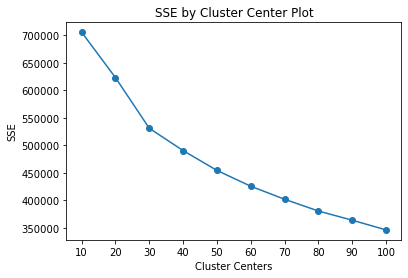

In [25]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 10)
    
    sse = []
    for k in iters:
        kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42, batch_size = 512)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 100)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

V = pd.unique(df_res['message'])
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/]{2,})')
X = vectorizer.fit_transform(V)

vectorizer.get_feature_names()

['//',
 'abs',
 'abstract',
 'access',
 'add',
 'age',
 'allowed',
 'ambiguity',
 'annotation',
 'applicable',
 'applied',
 'args',
 'argument',
 'arguments',
 'array',
 'arrayof',
 'asserted',
 'assignments',
 'bigdecimal',
 'biginteger',
 'block',
 'body',
 'boolean',
 'booleanarray',
 'box',
 'branch',
 'branches',
 'byte',
 'bytearray',
 'called',
 'calls',
 'candidates',
 'ch',
 'char',
 'character',
 'characters',
 'chararray',
 'charsequence',
 'class',
 'code',
 'collection',
 'collections',
 'color',
 'companion',
 'compareto',
 'component',
 'condition',
 'conflicting',
 'conform',
 'const',
 'constructor',
 'contains',
 'context',
 'count',
 'currency',
 'declaration',
 'declarations',
 'deeprecursivefunction',
 'defined',
 'destructuring',
 'div',
 'does',
 'dollar',
 'dollars',
 'double',
 'doublearray',
 'dualboot',
 'element',
 'elements',
 'entry',
 'enum',
 'equals',
 'error',
 'exhaustive',
 'expected',
 'expecting',
 'explicitly',
 'expression',
 'expressions',
 'fal

Fit 10 clusters. SSE 439642.39793235576
Fit 20 clusters. SSE 399324.7918806666
Fit 30 clusters. SSE 359324.36112612544
Fit 40 clusters. SSE 332419.14466591127
Fit 50 clusters. SSE 304052.8758748375
Fit 60 clusters. SSE 286159.0699672778
Fit 70 clusters. SSE 273418.9505926396
Fit 80 clusters. SSE 264452.4752353892
Fit 90 clusters. SSE 251710.22227935496
Fit 100 clusters. SSE 240367.90151989006


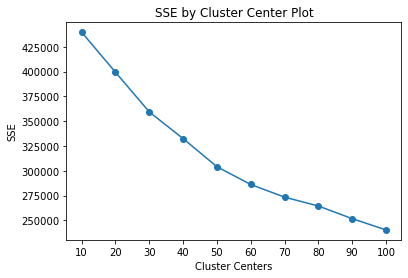

In [23]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 10)
    
    sse = []
    for k in iters:
        kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42, batch_size = 512)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 100)

In [64]:
true_k = 50

model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1, max_iter=100, random_state=42, batch_size = 512)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
val = model.inertia_
print('Fit {} clusters. SSE {}'.format(true_k,val))

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


print("\n")
print("Prediction")

Top terms per cluster:
Fit 50 clusters. SSE 304052.8758748375
Cluster 0:
 input
 unresolved
 reference
 error
 kt
 nmain
 string
 println
 val
 type
Cluster 1:
 message
 io
 inline
 unit
 npublic
 kotlin
 fun
 defined
 println
 ambiguity
Cluster 2:
 level
 declaration
 expecting
 kt
 nmain
 error
 println
 nprintln
 main
 nfun
Cluster 3:
 value
 parameter
 passed
 error
 kt
 nmain
 val
 required
 type
 annotation
Cluster 4:
 char
 letter
 isdigit
 applied
 boolean
 operator
 nval
 reference
 unresolved
 isvowel
Cluster 5:
 unresolved
 reference
 error
 kt
 nmain
 println
 variable
 return
 int
 nprintln
Cluster 6:
 print
 unresolved
 reference
 error
 nmain
 kt
 expecting
 readline
 element
 line
Cluster 7:
 type
 inferred
 mismatch
 expected
 int
 string
 return
 boolean
 error
 kt
Cluster 8:
 error
 nmain
 kt
 line
 tokens
 unexpected
 separate
 expressions
 use
 reference
Cluster 9:
 println
 unresolved
 reference
 error
 nmain
 kt
 expecting
 invocation
 yes
 expected
Cluster 10:
 

In [ ]:
import pandas as pd
from sklearn import metrics

V = pd.unique(df_res['reason'])
len(V)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english')
X = vectorizer.fit_transform(V)

vectorizer.get_feature_names()

In [490]:
# Kotlin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english')
X = vectorizer.fit_transform(V)

vectorizer.get_feature_names()

['abstract',
 'allowed',
 'applied',
 'argument',
 'arguments',
 'array',
 'boolean',
 'box',
 'char',
 'character',
 'characters',
 'class',
 'code',
 'component1',
 'component6',
 'conform',
 'const',
 'constructor',
 'corresponds',
 'declaration',
 'declared',
 'denote',
 'destructuring',
 'does',
 'dot',
 'double',
 'error',
 'expected',
 'expecting',
 'expression',
 'final',
 'floating',
 'fun',
 'function',
 'initializer',
 'inline',
 'int',
 'integer',
 'interface',
 'invocation',
 'invoke',
 'invoked',
 'kotlin',
 'label',
 'list',
 'literal',
 'local',
 'long',
 'loop',
 'map',
 'modifier',
 'mutablelist',
 'non',
 'null',
 'nullable',
 'open',
 'operator',
 'parameter',
 'parameters',
 'point',
 'println',
 'private',
 'property',
 'public',
 'qualified',
 'readline',
 'receiver',
 'return',
 'safe',
 'selector',
 'string',
 'type',
 'types',
 'unit',
 'value',
 'values',
 'variable']

In [491]:
X

<2602x77 sparse matrix of type '<class 'numpy.float64'>'
	with 9201 stored elements in Compressed Sparse Row format>

0.46037032916912074
Fit 10 clusters. SSE 1021.8861943668632
0.4879565644625842
Fit 15 clusters. SSE 830.275932382528
0.5403243448325018
Fit 20 clusters. SSE 696.8684476825258
0.585281293670369
Fit 25 clusters. SSE 586.4460924382876
0.6006221536180884
Fit 30 clusters. SSE 526.5588540699152
0.6072872839942981
Fit 35 clusters. SSE 491.00921703863224
0.6313211738948065
Fit 40 clusters. SSE 439.1150826943659
0.6490177358603145
Fit 45 clusters. SSE 378.67826304938245
0.649317731641244
Fit 50 clusters. SSE 362.9285156848322
0.6534745883170853
Fit 55 clusters. SSE 343.3649488480617
0.6622414239929297
Fit 60 clusters. SSE 318.4623755326294
0.6765265807210346
Fit 65 clusters. SSE 294.7911842095729
0.6839403727575298
Fit 70 clusters. SSE 270.5794177480002
0.6826644332703605
Fit 75 clusters. SSE 261.4287242967753
0.6874132412263104
Fit 80 clusters. SSE 252.45130067984377
0.6927223247595222
Fit 85 clusters. SSE 242.8532174701885
0.6990441690524535
Fit 90 clusters. SSE 233.2355532157481
0.7058049649

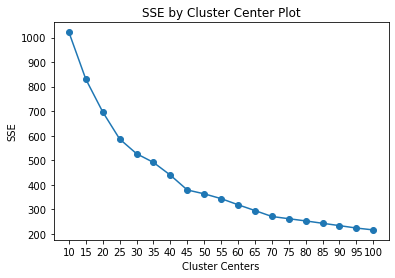

In [495]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 5)
    
    sse = []
    for k in iters:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        labels = kmeans_model.labels_
        print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 100)

In [496]:
true_k = 45

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 parameter
 type
 variable
 const
 error
 int
 parameters
 interface
 types
 does
Cluster 1:
 invocation
 function
 expected
 int
 char
 list
 integer
 code
 error
 map
Cluster 2:
 fun
 public
 arguments
 operator
 int
 kotlin
 values
 mutablelist
 list
 string
Cluster 3:
 characters
 character
 literal
 string
 println
 kotlin
 readline
 fun
 denote
 destructuring
Cluster 4:
 long
 destructuring
 initializer
 declaration
 component6
 type
 function
 component1
 array
 list
Cluster 5:
 expecting
 declaration
 class
 parameter
 variable
 argument
 open
 expression
 type
 function
Cluster 6:
 safe
 return
 code
 kotlin
 list
 string
 values
 loop
 char
 value
Cluster 7:
 qualified
 corresponds
 dot
 operator
 map
 double
 array
 null
 readline
 list
Cluster 8:
 invoked
 expression
 int
 type
 function
 mutablelist
 array
 list
 string
 long
Cluster 9:
 constructor
 public
 arguments
 array
 return
 string
 variable
 expected
 denote
 destructuring
Cluste

In [497]:
str = ["unresolved reference"]
v = vectorizer.transform(str)
model.predict(v)

array([0])

In [498]:
df_res['reason_1'] = model.predict(vectorizer.transform(df_res['reason']))
df_res

,language,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_1,reason_2,reason_message
0,kotlin,"fun main() {\n println(|Hello, World!)\n}\n","println(|Hello, World!)",2,13,"expecting an expression\n println(|Hello, W...",1724,27291,web,expecting an expression,5,10,expression expecting variable
1,kotlin,"fun main() {\n println(|Hello, World!)\n}\n","println(|Hello, World!)",2,13,"expecting an expression\n println(|Hello, W...",1724,27291,web,expecting an expression,5,10,expression expecting variable
2,kotlin,"fun main() {\n println(|Hello, World!)\n}\n","println(|Hello, World!)",2,19,"expecting an element\n println(|Hello, Worl...",1724,27291,web,expecting an element,5,15,element expecting variable
3,kotlin,"fun main() {\n println(|Hello, World!)\n}\n","println(|Hello, World!)",2,19,"expecting an element\n println(|Hello, Worl...",1724,27291,web,expecting an element,5,15,element expecting variable
4,kotlin,"fun main() {\n println(|Hello, World!)\n}\n","println(|Hello, World!)",2,5,overload resolution ambiguity: \npublic inline...,1724,27291,web,overload resolution ambiguity,0,5,ambiguity resolution overload
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032388,kotlin,class CountDownCounter(var count: Int) {\n ...,count--,4,6,unresolved reference: Synchronizied\n @Sync...,7480,28770248,web,unresolved reference,0,1,reference unresolved expected
1032389,kotlin,class CountDownCounter(var count: Int) {\n ...,count--,4,6,unresolved reference: synchronizied\n @sync...,7480,28770264,web,unresolved reference,0,1,reference unresolved expected
1032390,kotlin,class Account {\n\n var balance = 0L\n\n ...,Out of code,89,13,unresolved reference: balanc\n bala...,647,28556895,Idea,unresolved reference,0,1,reference unresolved expected
1032391,kotlin,class Account {\n\n var balance = 0L\n\n ...,Out of code,89,20,unresolved reference: -=\n balanc -...,647,28556895,Idea,unresolved reference,0,1,reference unresolved expected


In [499]:
df_res.groupby('reason_1')['message'].count().sort_values(ascending = False)

reason_1
0     531031
5     251945
32     65008
1      24964
15     17518
2      15429
35     14055
6      12989
21     12086
11     10616
19      9240
16      7606
42      6896
10      6378
41      5568
29      4885
18      4393
33      3852
3       3784
36      3170
9       2922
24      2645
17      1760
7       1722
40      1712
22      1577
14      1421
23      1314
30       900
43       892
20       684
39       601
34       585
28       559
37       424
31       303
13       252
38       160
44       153
25       112
4         89
8         72
26        61
27        31
12        29
Name: message, dtype: int64

In [501]:
pd.unique(df_res[df_res['reason_1']==0]['reason'])

array(['overload resolution ambiguity', 'unresolved reference',
       "unexpected tokens (use ';' to separate expressions on the same line)",
       'variable expected', 'variable must be initialized',
       'this variable must either have a type annotation or be initialized',
       'conflicting declarations', 'illegal underscore',
       'unclosed comment', 'parameter name expected',
       'a type annotation is required on a value parameter',
       'val cannot be reassigned',
       'unsupported [Collection literals outside of annotations]',
       'cannot infer a type for this parameter',
       'no value passed for parameter ',
       'not enough information to infer type variable T',
       'illegal escape', 'cannot find a parameter with this name',
       'names _, __, ___, ', 'assignment operators ambiguity',
       'classifier does not have a companion object, and thus must be initialized here',
       'type parameter name expected', "missing '>'",
       "not nullable valu

In [93]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/]{2,})')
X = vectorizer.fit_transform(df_res['reason'])

vectorizer.get_feature_names()

['access',
 'allowed',
 'ambiguity',
 'annotation',
 'applied',
 'arguments',
 'block',
 'body',
 'boolean',
 'branches',
 'called',
 'character',
 'component',
 'conflicting',
 'conform',
 'constructor',
 'declaration',
 'declarations',
 'destructuring',
 'does',
 'element',
 'expected',
 'expecting',
 'expression',
 'expressions',
 'following',
 'fun',
 'function',
 'functions',
 'incompatible',
 'initialized',
 'initializer',
 'inline',
 'integer',
 'invocation',
 'level',
 'line',
 'literal',
 'main',
 'member',
 'method',
 'mismatch',
 'modifier',
 'operator',
 'overload',
 'parameter',
 'passed',
 'println',
 'property',
 'public',
 'reassigned',
 'receiver',
 'reference',
 'required',
 'resolution',
 'safe',
 'separate',
 'string',
 'supplied',
 'toint',
 'tokens',
 'type',
 'types',
 'unexpected',
 'unresolved',
 'use',
 'used',
 'val',
 'value',
 'variable']

In [66]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-]{2,})')
X = vectorizer.fit_transform(df_res['reason'])

vectorizer.get_feature_names()

['age',
 'argument',
 'arguments',
 'array',
 'assignment',
 'block',
 'case',
 'character',
 'const',
 'constant',
 'declaration',
 'declared',
 'divide',
 'duplicate',
 'end',
 'error',
 'escape',
 'expected',
 'expression',
 'firstname',
 'float',
 'fmt',
 'function',
 'imported',
 'indirect',
 'int',
 'invalid',
 'lastname',
 'left',
 'literal',
 'main',
 'mismatch',
 'missing',
 'new',
 'newline',
 'operation',
 'package',
 'redeclared',
 'refer',
 'return',
 'string',
 'syntax',
 'type',
 'uint',
 'undefined',
 'unexported',
 'unknown',
 'updaterapper',
 'use',
 'used',
 'value',
 'variables']

Fit 10 clusters. SSE 8559.025268936555
Fit 14 clusters. SSE 5937.650557777917
Fit 18 clusters. SSE 4668.929297916784
Fit 22 clusters. SSE 3845.5875771865663
Fit 26 clusters. SSE 2945.195265879457
Fit 30 clusters. SSE 2268.327717002852
Fit 34 clusters. SSE 1867.6407110785294
Fit 38 clusters. SSE 1448.1277281103849
Fit 42 clusters. SSE 1203.7593253984364
Fit 46 clusters. SSE 1083.2640938822603
Fit 50 clusters. SSE 1221.4973241229206
Fit 54 clusters. SSE 1174.04552588914
Fit 58 clusters. SSE 1331.0080746309136
Fit 62 clusters. SSE 1058.9283696159039
Fit 66 clusters. SSE 1247.203763007902
Fit 70 clusters. SSE 1324.0011277510669
Fit 74 clusters. SSE 1418.7669037363949
Fit 78 clusters. SSE 1417.098885986579
Fit 82 clusters. SSE 1329.9505280443818
Fit 86 clusters. SSE 1454.1618148174089
Fit 90 clusters. SSE 1456.6888808028102
Fit 94 clusters. SSE 1302.9787060139877
Fit 98 clusters. SSE 1451.3858175621583


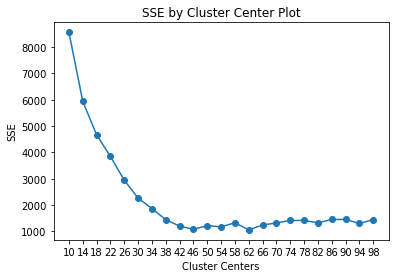

In [67]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 4)
    
    sse = []
    for k in iters:
        kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42, batch_size = 512)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 100)

In [68]:
true_k = 46

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 undefined
 variables
 divide
 function
 fmt
 float
 firstname
 expression
 expected
 escape
Cluster 1:
 error
 syntax
 variables
 divide
 function
 fmt
 float
 firstname
 expression
 expected
Cluster 2:
 assignment
 string
 use
 type
 value
 new
 float
 literal
 error
 uint
Cluster 3:
 character
 invalid
 duplicate
 imported
 function
 fmt
 float
 firstname
 expression
 expected
Cluster 4:
 expression
 declaration
 const
 type
 variables
 duplicate
 function
 fmt
 float
 firstname
Cluster 5:
 block
 redeclared
 int
 left
 array
 lastname
 duplicate
 fmt
 float
 firstname
Cluster 6:
 divide
 arguments
 duplicate
 imported
 function
 fmt
 float
 firstname
 expression
 expected
Cluster 7:
 refer
 unexported
 declared
 function
 fmt
 float
 firstname
 expression
 expected
 escape
Cluster 8:
 use
 type
 invalid
 variables
 divide
 fmt
 float
 firstname
 expression
 expected
Cluster 9:
 declared
 used
 value
 int
 lastname
 string
 return
 divide
 float
 fi

In [69]:
classter_name = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    name = ""
    for ind in order_centroids[i, :3]:
        name += terms[ind] + " "
    classter_name[i] = name.strip()    
classter_name   

{0: 'undefined variables divide',
 1: 'error syntax variables',
 2: 'assignment string use',
 3: 'character invalid duplicate',
 4: 'expression declaration const',
 5: 'block redeclared int',
 6: 'divide arguments duplicate',
 7: 'refer unexported declared',
 8: 'use type invalid',
 9: 'declared used value',
 10: 'left variables new',
 11: 'expected newline fmt',
 12: 'value missing const',
 13: 'package fmt use',
 14: 'updaterapper argument string',
 15: 'age int use',
 16: 'missing argument duplicate',
 17: 'imported used divide',
 18: 'return arguments main',
 19: 'fmt refer unexported',
 20: 'operation invalid string',
 21: 'main block redeclared',
 22: 'end function missing',
 23: 'argument return type',
 24: 'literal character invalid',
 25: 'argument indirect invalid',
 26: 'mismatch assignment variables',
 27: 'unknown escape literal',
 28: 'case duplicate invalid',
 29: 'array float literal',
 30: 'int type assignment',
 31: 'newline string variables',
 32: 'constant int const

In [70]:
df_res['reason_1'] = model.predict(vectorizer.transform(df_res['reason']))
df_res

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_2,reason_2_message,reason_1
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web,syntax error,1,error syntax error syntax,1
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const,4
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const,4
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...,12
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40064,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Moscow := UTC.Add(3 * time.Hour),11,5,Moscow declared but not used\n./main.go:12:5: ...,578,22230727,web,Moscow declared but not used,19,declared used declared used,9
40065,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",NewYork := UTC.Add(-4 * time.Hour),12,5,NewYork declared but not used\n./main.go:13:5:...,578,22230727,web,NewYork declared but not used,19,declared used declared used,9
40066,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",HongKong := UTC.Add(8 * time.Hour),13,5,HongKong declared but not used\n./main.go:14:5...,578,22230727,web,HongKong declared but not used,19,declared used declared used,9
40067,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Tokyo := UTC.Add(9 * time.Hour),14,5,Tokyo declared but not used\n./main.go:15:5: D...,578,22230727,web,Tokyo declared but not used,19,declared used declared used,9


In [71]:
df_res['reason_1_message'] = df_res['reason_1'].map(lambda x: classter_name[x])
df_res

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_2,reason_2_message,reason_1,reason_1_message
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web,syntax error,1,error syntax error syntax,1,error syntax variables
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const,4,expression declaration const
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const,4,expression declaration const
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...,12,value missing const
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...,12,value missing const
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40064,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Moscow := UTC.Add(3 * time.Hour),11,5,Moscow declared but not used\n./main.go:12:5: ...,578,22230727,web,Moscow declared but not used,19,declared used declared used,9,declared used value
40065,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",NewYork := UTC.Add(-4 * time.Hour),12,5,NewYork declared but not used\n./main.go:13:5:...,578,22230727,web,NewYork declared but not used,19,declared used declared used,9,declared used value
40066,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",HongKong := UTC.Add(8 * time.Hour),13,5,HongKong declared but not used\n./main.go:14:5...,578,22230727,web,HongKong declared but not used,19,declared used declared used,9,declared used value
40067,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Tokyo := UTC.Add(9 * time.Hour),14,5,Tokyo declared but not used\n./main.go:15:5: D...,578,22230727,web,Tokyo declared but not used,19,declared used declared used,9,declared used value


In [56]:
vectorizer = vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/.]{2,})', ngram_range = {1,3})
X = vectorizer.fit_transform(df_res['reason'])

vectorizer.get_feature_names()

['age',
 'age type',
 'age type int',
 'argument',
 'argument updaterapper',
 'arguments',
 'arguments divide',
 'arguments return',
 'array',
 'assignment',
 'assignment mismatch',
 'block',
 'case',
 'character',
 'character literal',
 'const',
 'const declaration',
 'const declaration type',
 'constant',
 'declaration',
 'declaration type',
 'declaration type expression',
 'declared',
 'declared used',
 'divide',
 'duplicate',
 'duplicate case',
 'end',
 'end function',
 'error',
 'escape',
 'expected',
 'expression',
 'firstname',
 'firstname type',
 'firstname type string',
 'float',
 'fmt',
 'function',
 'imported',
 'imported used',
 'indirect',
 'int',
 'int assignment',
 'invalid',
 'invalid character',
 'invalid character literal',
 'invalid indirect',
 'invalid operation',
 'lastname',
 'lastname type',
 'lastname type string',
 'left',
 'literal',
 'main',
 'main redeclared',
 'main redeclared block',
 'mismatch',
 'missing',
 'missing return',
 'missing return end',
 'miss

Fit 10 clusters. SSE 9626.806537646928
Fit 14 clusters. SSE 7518.496911316107
Fit 18 clusters. SSE 5686.498229418971
Fit 22 clusters. SSE 4931.514973440823
Fit 26 clusters. SSE 3954.8891033011478
Fit 30 clusters. SSE 3077.575983833086
Fit 34 clusters. SSE 2673.4105726492444
Fit 38 clusters. SSE 2089.6548152353153
Fit 42 clusters. SSE 1508.4193254343572
Fit 46 clusters. SSE 1515.5138840901081
Fit 50 clusters. SSE 1648.1503970922538
Fit 54 clusters. SSE 1266.1609100928024
Fit 58 clusters. SSE 1221.3835774525862
Fit 62 clusters. SSE 1267.1355155435983
Fit 66 clusters. SSE 1374.7962645849423
Fit 70 clusters. SSE 1460.439166750813
Fit 74 clusters. SSE 1828.7318099337294
Fit 78 clusters. SSE 1733.8864254313326
Fit 82 clusters. SSE 1663.546012752573
Fit 86 clusters. SSE 1596.066885532016
Fit 90 clusters. SSE 1661.2212488132698
Fit 94 clusters. SSE 1432.3412192891512
Fit 98 clusters. SSE 1640.6598842851708


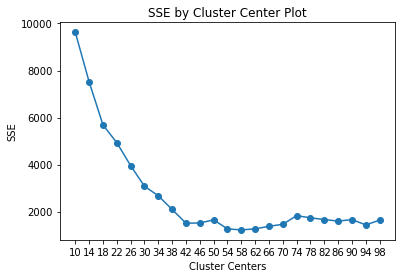

In [57]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 4)
    
    sse = []
    for k in iters:
        kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42, batch_size = 512)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 100)

In [62]:
true_k = 42

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 undefined
 variables left
 end function
 escape
 expected
 expression
 firstname
 firstname type
 firstname type string
 float
Cluster 1:
 error
 syntax error
 syntax
 indirect
 escape
 expected
 expression
 firstname
 firstname type
 firstname type string
Cluster 2:
 string return
 type string return
 string return argument
 return argument
 return
 type string
 string
 argument
 type
 use
Cluster 3:
 missing value
 missing value const
 value const declaration
 value const
 value
 missing
 const declaration
 const
 declaration
 firstname
Cluster 4:
 character
 invalid
 invalid character
 int
 expected
 expression
 firstname
 firstname type
 firstname type string
 float
Cluster 5:
 updaterapper
 arguments
 int assignment
 expected
 expression
 firstname
 firstname type
 firstname type string
 float
 fmt
Cluster 6:
 refer
 unexported
 refer unexported
 refer unexported fmt
 unexported fmt
 fmt
 variables left
 expected
 expression
 firstname
Cluster 7:

In [63]:
classter_name = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    name = ""
    for ind in order_centroids[i, :3]:
        name += terms[ind] + " "
    classter_name[i] = name.strip()    
classter_name   

{0: 'undefined variables left end function',
 1: 'error syntax error syntax',
 2: 'string return type string return string return argument',
 3: 'missing value missing value const value const declaration',
 4: 'character invalid invalid character',
 5: 'updaterapper arguments int assignment',
 6: 'refer unexported refer unexported',
 7: 'invalid indirect indirect invalid',
 8: 'invalid operation operation invalid',
 9: 'expected newline fmt',
 10: 'string argument type string argument argument',
 11: 'missing return end function end',
 12: 'case duplicate case duplicate',
 13: 'redeclared block block redeclared',
 14: 'arguments return return arguments',
 15: 'main redeclared main redeclared block main',
 16: 'arguments divide divide arguments',
 17: 'imported used imported used',
 18: 'age use age int',
 19: 'declared used declared used',
 20: 'use fmt invalid',
 21: 'expression const declaration const',
 22: 'lastname type use lastname type use lastname',
 23: 'used value use',
 24: 

In [64]:
df_res['reason_2'] = model.predict(vectorizer.transform(df_res['reason']))
df_res

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_2,reason_2_message
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web,syntax error,1,error syntax error syntax
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,type expression declaration type expression de...
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,type expression declaration type expression de...
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40064,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Moscow := UTC.Add(3 * time.Hour),11,5,Moscow declared but not used\n./main.go:12:5: ...,578,22230727,web,Moscow declared but not used,19,declared used declared used
40065,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",NewYork := UTC.Add(-4 * time.Hour),12,5,NewYork declared but not used\n./main.go:13:5:...,578,22230727,web,NewYork declared but not used,19,declared used declared used
40066,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",HongKong := UTC.Add(8 * time.Hour),13,5,HongKong declared but not used\n./main.go:14:5...,578,22230727,web,HongKong declared but not used,19,declared used declared used
40067,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Tokyo := UTC.Add(9 * time.Hour),14,5,Tokyo declared but not used\n./main.go:15:5: D...,578,22230727,web,Tokyo declared but not used,19,declared used declared used


In [65]:
df_res['reason_2_message'] = df_res['reason_2'].map(lambda x: classter_name[x])
df_res

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_2,reason_2_message
0,go,14473,"// Declare a ""chest"" variable\r\nchest := ""gol...",Out of code,5,1,syntax error: non-declaration statement outsid...,99,0,web,syntax error,1,error syntax error syntax
1,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const
2,go,14474,const (\n Winter iota\n Spring\n Summ...,Autumn,5,12,const declaration cannot have type without exp...,53,1919,web,const declaration cannot have type without exp...,21,expression const declaration const
3,go,14474,const (\n Winter iota\n Spring\n Summ...,),6,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...
4,go,14474,const (\n Winter iota\n Spring\n Summ...,Out of code,7,5,missing value in const declaration\n./main.go:...,53,1919,web,missing value in const declaration,3,missing value missing value const value const ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40064,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Moscow := UTC.Add(3 * time.Hour),11,5,Moscow declared but not used\n./main.go:12:5: ...,578,22230727,web,Moscow declared but not used,19,declared used declared used
40065,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",NewYork := UTC.Add(-4 * time.Hour),12,5,NewYork declared but not used\n./main.go:13:5:...,578,22230727,web,NewYork declared but not used,19,declared used declared used
40066,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",HongKong := UTC.Add(8 * time.Hour),13,5,HongKong declared but not used\n./main.go:14:5...,578,22230727,web,HongKong declared but not used,19,declared used declared used
40067,go,19303,"package main\n\nimport (\n ""fmt""\n ""time...",Tokyo := UTC.Add(9 * time.Hour),14,5,Tokyo declared but not used\n./main.go:15:5: D...,578,22230727,web,Tokyo declared but not used,19,declared used declared used


In [124]:
df_tasks[(df_tasks['rate']<0.5) & (df_tasks['total']>1000)]

solution_label,CE,Check error,Correct,"Correct, unknown style",RE,Style,TL,WA,total,rate
step_id,,,,,,,,,,
4451,3071,0,4263,0,1688,2161,25,2552,13760,0.466860
4491,1327,0,1159,0,74,1421,13,1265,5259,0.490588
4496,1428,0,1092,0,293,1557,8,1300,5678,0.466538
4497,1269,203,1004,0,161,1045,7,567,4256,0.481438
4499,1818,0,1547,0,90,1724,2,3149,8330,0.392677
...,...,...,...,...,...,...,...,...,...,...
16587,0,0,0,231,433,0,1,1396,2061,0.112082
16588,0,0,0,262,406,0,0,1071,1739,0.150661
16589,0,0,0,311,362,0,0,1254,1927,0.161391


In [72]:
s_errors = df_res.groupby('reason_1_message')['code'].count()

r_errors = pd.DataFrame({'type':s_errors.index, 'number':s_errors.values})
r_errors['percentage_all']= (r_errors['number']/r_errors['number'].sum()) * 100

r_errors

,type,number,percentage_all
0,age int use,396,0.988295
1,argument indirect invalid,128,0.319449
2,argument return type,369,0.920911
3,arguments updaterapper fmt,356,0.888467
4,array float literal,276,0.688812
5,assignment string use,276,0.688812
6,block redeclared int,407,1.015748
7,case duplicate invalid,336,0.838553
8,character invalid duplicate,769,1.919189
9,constant int const,134,0.334423


In [126]:
df_1 = df_res[df_res['step_id']==4451]
df_1

,language,step_id,code,code_part,string,symbol,message,user_id,sub_id,client,reason,reason_1,reason_1_message,reason_2,reason_2_message
6303,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,string = scanner.nest(),8,9,unresolved reference: string\n string =...,3489,18009,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
6304,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,string = scanner.nest(),8,26,unresolved reference: nest\n string = s...,3489,18009,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
6305,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,printl(string),9,9,unresolved reference: printl\n printl(s...,3489,18009,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
6306,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,printl(string),9,16,unresolved reference: string\n printl(s...,3489,18009,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
6307,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,str = scanner.nest(),8,23,unresolved reference: nest\n str = scan...,3489,18019,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928655,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,println(c),12,13,variable 'c' must be initialized\n println(...,18091,29302861,web,variable must be initialized,0,initialized variable annotation,19,variable initialized initialized variable
928656,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,println(d),13,5,overload resolution ambiguity: \npublic inline...,18091,29302861,web,overload resolution ambiguity,8,ambiguity resolution overload,4,resolution resolution ambiguity overload resol...
928657,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,println(d),13,13,variable 'd' must be initialized\n println(...,18091,29302861,web,variable must be initialized,0,initialized variable annotation,19,variable initialized initialized variable
928658,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,println(e),14,5,overload resolution ambiguity: \npublic inline...,18091,29302861,web,overload resolution ambiguity,8,ambiguity resolution overload,4,resolution resolution ambiguity overload resol...


In [73]:
df_1.groupby('reason_1_message')['code'].count().nlargest(5)

NameError: name 'df_1' is not defined

In [165]:
s_errors = df_1.groupby('reason_1_message')['code'].count()

df_1_errors = pd.DataFrame({'type':s1_errors.index, 'number':s1_errors.values})
df_1_errors['percentage'] = (df_1_errors['number']/df_1_errors['number'].sum()) * 100

df_1_errors

,type,number,percentage
0,access method required,71,0.540253
1,allowed parameter function,84,0.639172
2,ambiguity resolution overload,1487,11.314868
3,body block function,1,0.007609
4,boolean conform does,21,0.159793
5,conflicting variable declarations,10,0.076092
6,conform does integer,1,0.007609
7,declarations conflicting variable,832,6.330848
8,element expecting variable,813,6.186273
9,expecting type variable,690,5.250342


In [172]:
df_1_errors_join = df_1_errors.join(r_errors.set_index('type'), on='type', rsuffix='_right')
df_1_errors_join

,type,number,percentage,number_right,percentage_all
0,access method required,71,0.540253,6744,0.653240
1,allowed parameter function,84,0.639172,8836,0.855876
2,ambiguity resolution overload,1487,11.314868,35348,3.423890
3,body block function,1,0.007609,10878,1.053669
4,boolean conform does,21,0.159793,6990,0.677068
5,conflicting variable declarations,10,0.076092,5397,0.522766
6,conform does integer,1,0.007609,8488,0.822168
7,declarations conflicting variable,832,6.330848,30749,2.978420
8,element expecting variable,813,6.186273,33682,3.262517
9,expecting type variable,690,5.250342,63263,6.127802


In [173]:
df_1_errors_join['percentage_diff'] = df_1_errors_join['percentage_all'] -df_1_errors_join['percentage'] 
df_1_errors_join

,type,number,percentage,number_right,percentage_all,percentage_diff
0,access method required,71,0.540253,6744,0.653240,0.112987
1,allowed parameter function,84,0.639172,8836,0.855876,0.216704
2,ambiguity resolution overload,1487,11.314868,35348,3.423890,-7.890978
3,body block function,1,0.007609,10878,1.053669,1.046059
4,boolean conform does,21,0.159793,6990,0.677068,0.517275
5,conflicting variable declarations,10,0.076092,5397,0.522766,0.446674
6,conform does integer,1,0.007609,8488,0.822168,0.814558
7,declarations conflicting variable,832,6.330848,30749,2.978420,-3.352428
8,element expecting variable,813,6.186273,33682,3.262517,-2.923756
9,expecting type variable,690,5.250342,63263,6.127802,0.877460


In [178]:
df_1_errors_join.sort_values(by='percentage_diff',ascending=True).iloc[:5,:] 

,type,number,percentage,number_right,percentage_all,percentage_diff
31,unresolved reference variable,5531,42.086440,309574,29.986062,-12.100379
2,ambiguity resolution overload,1487,11.314868,35348,3.423890,-7.890978
7,declarations conflicting variable,832,6.330848,30749,2.978420,-3.352428
8,element expecting variable,813,6.186273,33682,3.262517,-2.923756
16,invocation function expected,588,4.474205,27630,2.676306,-1.797898


In [135]:
df_first = df_1.groupby('user_id').first().reset_index()
df_first

,user_id,language,step_id,code,code_part,string,symbol,message,sub_id,client,reason,reason_1,reason_1_message,reason_2,reason_2_message
0,1,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,val s1 = scanner.next();,5,9,"conflicting declarations: val s1: String!, val...",10058429,web,conflicting declarations,9,declarations conflicting variable,11,conflicting declarations declarations conflicting
1,12,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,println(scanner.next) * 5,5,21,function invocation 'next()' expected\n pri...,16278510,web,function invocation 'next' expected,7,invocation function expected,10,invocation function invocation function
2,80,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,},14,2,expecting '}'\n}\n ^\nmain.kt:9:24: error: typ...,8262134,web,expecting '}',5,expecting type variable,3,expecting variable initialized expecting member
3,103,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,for(i in 0..4) prinln(scanner.next()),5,20,unresolved reference: prinln\n for(i in 0.....,9942179,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
4,104,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,"for (i in scanner.plit("" "")) {",7,20,unresolved reference: plit\n for (i in scanner...,15825935,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,17938,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,val w1 = read.next(),5,14,unresolved reference: read\n val w1 = read....,29022407,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
1269,17959,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,val first = Scanner.next(),6,25,unresolved reference: next\n val first = Sc...,29125201,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
1270,17969,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,while(scanner.nexLine() != null){,5,19,unresolved reference: nexLine\n while(scann...,29201486,web,unresolved reference,1,unresolved reference variable,0,reference unresolved unresolved reference
1271,18022,kotlin,4451,import java.util.Scanner\n\nfun main() {\n ...,while(var next = scanner.next()){,6,11,expecting an expression\n while(var next = ...,29282390,web,expecting an expression,2,expression expecting expected,9,expecting expression expression expecting


In [136]:
df_first.groupby('reason_1_message')['code'].count().nlargest(5)

reason_1_message
unresolved reference variable        563
expecting type variable              163
declarations conflicting variable    127
invocation function expected          92
element expecting variable            46
Name: code, dtype: int64

In [31]:
r = df_res.groupby('reason_2')['message'].count().sort_values(ascending = False)

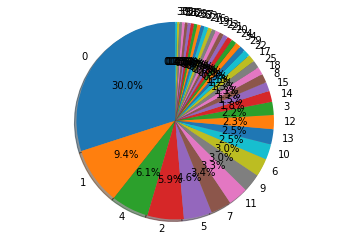

In [32]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(r.keys())
sizes = list(r)
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [510]:
df_res.groupby('reason_2')['message'].count().sort_values(ascending = False)

reason_2
8     471018
11    250987
27     66618
29     28588
24     26276
2      25352
19     17521
4      15477
15     14083
6      12984
42     12026
9      10611
5       9555
39      9013
40      8683
10      6985
22      6378
33      5568
41      4885
0       4476
14      4245
3       3784
17      2645
1       1722
23      1713
13      1577
26      1421
25      1319
21      1314
35       893
12       746
28       601
34       597
38       585
30       482
7        465
44       316
31       252
20       236
16       112
37        81
32        61
18        61
43        46
36        35
Name: message, dtype: int64

In [75]:
df_styles = df[df['solution_label'] == 'Style']
df_styles

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label
19,4368,2,AndroidStudio,3571,160182,"{""choices"": null, ""score"": null, ""solution"": n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
24,4368,2,web,3581,193594,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
25,4368,2,web,3581,193659,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
44,4368,2,web,3406,208587,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
45,4368,2,web,3406,208616,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
...,...,...,...,...,...,...,...,...
1373298,17903,2,web,7480,28770566,"{""language"": ""kotlin"", ""code"": ""class Counter ...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
1373304,17908,2,Idea,647,28556990,"{""choices"": null, ""score"": """", ""solution"": nul...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
1373306,17908,2,web,9468,28686802,"{""language"": ""kotlin"", ""code"": ""class Account ...","{""message"": """", ""code_style"": {""quality"": {""co...",Style
1373308,17908,2,idea,16720,28747369,"{""choices"": null, ""score"": """", ""solution"": nul...","{""message"": """", ""code_style"": {""quality"": {""co...",Style


In [76]:
def style_quality(row):
    json_data = json.loads(row['feedback'],strict=False)
    try:
        return json_data['code_style']['quality']['code']
    except:
        return "UND"


df_styles['quality'] = df_styles.apply(lambda row: style_quality(row), axis=1)
df_styles

,step_id,status,client,uid_anon,id_anon,reply,feedback,solution_label,quality
19,4368,2,AndroidStudio,3571,160182,"{""choices"": null, ""score"": null, ""solution"": n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,GOOD
24,4368,2,web,3581,193594,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,MODERATE
25,4368,2,web,3581,193659,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,MODERATE
44,4368,2,web,3406,208587,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,GOOD
45,4368,2,web,3406,208616,"{""language"": ""kotlin"", ""code"": ""fun main() {\n...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,GOOD
...,...,...,...,...,...,...,...,...,...
1373298,17903,2,web,7480,28770566,"{""language"": ""kotlin"", ""code"": ""class Counter ...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,GOOD
1373304,17908,2,Idea,647,28556990,"{""choices"": null, ""score"": """", ""solution"": nul...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,GOOD
1373306,17908,2,web,9468,28686802,"{""language"": ""kotlin"", ""code"": ""class Account ...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,BAD
1373308,17908,2,idea,16720,28747369,"{""choices"": null, ""score"": """", ""solution"": nul...","{""message"": """", ""code_style"": {""quality"": {""co...",Style,BAD


In [77]:
df_styles.groupby('quality')['id_anon'].count().sort_values(ascending = False)

quality
GOOD         136108
EXCELLENT     66969
BAD           56209
MODERATE      48685
Name: id_anon, dtype: int64

In [78]:
res_list = []
def style_place(row):
    list = []
    json_data = json.loads(row['feedback'],strict=False)
    for i in json_data['code_style']['errors']:
        d = {}
        reply_data = json.loads(row['reply'],strict=False)
        d['user_id'] = row['uid_anon']
        d['sub_id'] = row['id_anon']
        d['language'] = reply_data['language']
        d['code'] = reply_data['code']
        d['quality'] =  row['quality']
        d['type'] = i['code']
        d['text'] = i['text']
        d['code_part'] = i['line']
        d['string'] = i['line_number']            
        d['symbol'] = i['column_number']
        try:
            d['difficulty'] = i['difficulty']
        except:
            d['difficulty'] = ""
        list.append(d)
        res_list.append(d)
    return list


df_styles['data'] =df_styles.apply(lambda row: style_place(row), axis=1)
df_styles['data']

19         [{'user_id': 3571, 'sub_id': 160182, 'language...
24         [{'user_id': 3581, 'sub_id': 193594, 'language...
25         [{'user_id': 3581, 'sub_id': 193659, 'language...
44         [{'user_id': 3406, 'sub_id': 208587, 'language...
45         [{'user_id': 3406, 'sub_id': 208616, 'language...
                                 ...                        
1373298    [{'user_id': 7480, 'sub_id': 28770566, 'langua...
1373304    [{'user_id': 647, 'sub_id': 28556990, 'languag...
1373306    [{'user_id': 9468, 'sub_id': 28686802, 'langua...
1373308    [{'user_id': 16720, 'sub_id': 28747369, 'langu...
1373309    [{'user_id': 7805, 'sub_id': 29085194, 'langua...
Name: data, Length: 307971, dtype: object

In [79]:
df_style = pd.DataFrame(res_list)
df_style

,user_id,sub_id,language,code,quality,type,text,code_part,string,symbol,difficulty
0,3571,160182,kotlin,"fun main() {\n println(""Hello, World!"")\n}",GOOD,Indentation,Unexpected indentation (3) (it should be 4),fun main() {,0,12,
1,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,
2,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,
3,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,
4,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,
...,...,...,...,...,...,...,...,...,...,...,...
976534,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return false,8,0,EASY
976535,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (9) (should be 8),} else {,9,0,EASY
976536,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),balance -= amount,10,0,EASY
976537,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return true,11,0,EASY


In [80]:
df_style.groupby('text')['sub_id'].count().sort_values(ascending = False)

text
This expression contains a magic number. Consider defining it to a well named constant.                                                               210831
Unexpected indentation (0) (should be 4)                                                                                                               54730
Missing spacing before "{"                                                                                                                             39769
Missing space after //                                                                                                                                 25925
Missing spacing after ","                                                                                                                              22114
                                                                                                                                                       ...  
Parentheses in (num1 > CERO && num2 <= CERO && num3 <

In [81]:
def clean(s):
    s1 = re.sub("\'\\b[^']*\\b\'","",s)
    s1 = re.sub("\\([^']*\\)","",s1)
    s1 = re.sub("\\b[0-9][0-9.,-_]*\\b", '', s1)
    s1 = re.sub (r' +', ' ',s1)
    find = re.compile(r"^[^.\\:]*")
    return re.search(find, s1).group(0)

In [82]:
df_style['message'] = df_style['text'].map(lambda x: clean(x))
df_style

,user_id,sub_id,language,code,quality,type,text,code_part,string,symbol,difficulty,message
0,3571,160182,kotlin,"fun main() {\n println(""Hello, World!"")\n}",GOOD,Indentation,Unexpected indentation (3) (it should be 4),fun main() {,0,12,,Unexpected indentation
1,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation
2,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation
3,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation
4,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation
...,...,...,...,...,...,...,...,...,...,...,...,...
976534,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return false,8,0,EASY,Unexpected indentation
976535,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (9) (should be 8),} else {,9,0,EASY,Unexpected indentation
976536,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),balance -= amount,10,0,EASY,Unexpected indentation
976537,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return true,11,0,EASY,Unexpected indentation


In [83]:
df_style.groupby('message')['sub_id'].count().sort_values(ascending = False)

message
This expression contains a magic number                    210831
Unexpected indentation                                     186308
Missing spacing before "{"                                  39769
Variable could be val                                       39268
Parentheses in are unnecessary and can be replaced with     37259
                                                            ...  
Parentheses in / countC                                         1
Parentheses in / allChar *                                      1
Parentheses in / adn                                            1
Parentheses in / a!!                                            1
Parentheses in +sec2                                            1
Name: sub_id, Length: 1339, dtype: int64

In [531]:
vectorizer = TfidfVectorizer(min_df = 5,  stop_words ='english')
X = vectorizer.fit_transform(pd.unique(df_style['message']))

vectorizer.get_feature_names()

['array',
 'begin',
 'braces',
 'case',
 'ch',
 'char',
 'character',
 'check',
 'class',
 'code',
 'confession',
 'const',
 'data',
 'deeply',
 'defines',
 'detected',
 'explicitly',
 'expression',
 'false',
 'function',
 'functionality',
 'headphones',
 'holds',
 'input',
 'line',
 'list',
 'marked',
 'match',
 'missing',
 'multiple',
 'names',
 'nested',
 'newline',
 'num',
 'number',
 'object',
 'order',
 'parameter',
 'parameters',
 'parentheses',
 'pattern',
 'pi',
 'positive',
 'public',
 'replaced',
 'return',
 'smartphone',
 'space',
 'spacing',
 'statements',
 'string',
 'true',
 'tv',
 'type',
 'unexpected',
 'unit',
 'unnecessary',
 'using',
 'val',
 'value',
 'weekend',
 'zero']

In [103]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english')
X = vectorizer.fit_transform(df_style['message'])

vectorizer.get_feature_names()

['blank',
 'braces',
 'class',
 'code',
 'const',
 'contains',
 'data',
 'defined',
 'defines',
 'detected',
 'does',
 'expression',
 'functionality',
 'holds',
 'increase',
 'indentation',
 'length',
 'line',
 'literal',
 'longer',
 'magic',
 'match',
 'maximum',
 'missing',
 'multi',
 'names',
 'needless',
 'newline',
 'number',
 'numeric',
 'order',
 'parentheses',
 'pattern',
 'readability',
 'replaced',
 'semicolon',
 'separated',
 'space',
 'spacing',
 'statement',
 'style',
 'underscores',
 'unexpected',
 'unnecessary',
 'val',
 'variable']

Fit 10 clusters. SSE 109675.78252684147
Fit 13 clusters. SSE 69717.483386861
Fit 16 clusters. SSE 39616.44465153128
Fit 19 clusters. SSE 25352.539306182327
Fit 22 clusters. SSE 12418.340207395655
Fit 25 clusters. SSE 5351.136242398072
Fit 28 clusters. SSE 2573.346412480666
Fit 31 clusters. SSE 1420.8982618109776
Fit 34 clusters. SSE 601.4177061823661
Fit 37 clusters. SSE 92.28501857983737
Fit 40 clusters. SSE 21.774722917270445
Fit 43 clusters. SSE 5.9225415395747625
Fit 46 clusters. SSE 1.9049510115058172
Fit 49 clusters. SSE 0.14133679910329333
Fit 52 clusters. SSE 1.2829737272568309e-12


<ipython-input-105-fb97320e3915>:7: ConvergenceWarning: Number of distinct clusters (50) found smaller than n_clusters (52). Possibly due to duplicate points in X.
  kmeans_model.fit(data)


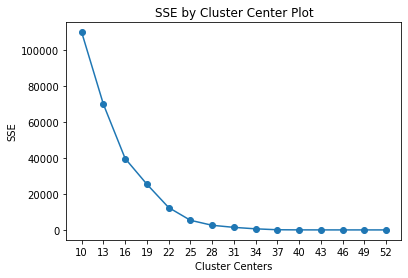

In [105]:
def find_optimal_clusters(data, max_k):
    iters = range(10, max_k, 3)
    
    sse = []
    for k in iters:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 55)

In [128]:
true_k = 26

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 expression contains magic
 expression contains
 contains magic
 contains magic number
 magic number
 magic
 number
 contains
 expression
 variable val
Cluster 1:
 missing spacing
 spacing
 missing
 variable val
 line detected
 functionality holds data
 holds
 holds data
 increase
 increase readability
Cluster 2:
 indentation
 unexpected indentation
 unexpected
 variable val
 line detected
 functionality holds
 functionality holds data
 holds
 holds data
 increase
Cluster 3:
 missing space
 missing space //
 space //
 //
 space
 missing
 line
 functionality holds data
 holds
 holds data
Cluster 4:
 variable val
 val
 variable
 line detected
 functionality holds
 functionality holds data
 holds
 holds data
 increase
 increase readability
Cluster 5:
 unexpected spacing
 unexpected
 spacing
 variable val
 line detected
 functionality holds
 functionality holds data
 holds
 holds data
 increase
Cluster 6:
 unnecessary replaced
 replaced
 parentheses unnece

In [129]:
df_style['reason'] = model.predict(vectorizer.transform(df_style['message']))
df_style

,user_id,sub_id,language,code,quality,type,text,code_part,string,symbol,difficulty,message,reason,reason_3
0,3571,160182,kotlin,"fun main() {\n println(""Hello, World!"")\n}",GOOD,Indentation,Unexpected indentation (3) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,2
1,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,2
2,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation,2,2
3,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,2
4,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976534,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return false,8,0,EASY,Unexpected indentation,2,2
976535,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (9) (should be 8),} else {,9,0,EASY,Unexpected indentation,2,2
976536,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),balance -= amount,10,0,EASY,Unexpected indentation,2,2
976537,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return true,11,0,EASY,Unexpected indentation,2,2


In [130]:
df_style.groupby('reason')['message'].count().sort_values(ascending = False)

reason
1     228017
0     210831
2     186308
5      49498
4      39268
6      37268
3      28656
8      19949
9      18393
13     18050
7      17216
10     17123
14     14058
12     12664
11     12373
17     11409
15     11341
18      9083
20      9004
16      5993
21      5778
22      4438
23      3871
19      3418
24      1309
25      1223
Name: message, dtype: int64

In [131]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/.]{2,})', ngram_range = {1,3})
X = vectorizer.fit_transform(df_style['message'])

vectorizer.get_feature_names()

['//',
 'blank',
 'blank line',
 'braces',
 'class',
 'code',
 'code style',
 'const',
 'const val',
 'contains',
 'contains magic',
 'contains magic number',
 'data',
 'defined',
 'defined maximum',
 'defined maximum line',
 'defines',
 'defines functionality',
 'defines functionality holds',
 'detected',
 'detected longer',
 'detected longer defined',
 'does',
 'does braces',
 'expression',
 'expression contains',
 'expression contains magic',
 'functionality',
 'functionality holds',
 'functionality holds data',
 'holds',
 'holds data',
 'increase',
 'increase readability',
 'indentation',
 'length',
 'length code',
 'length code style',
 'line',
 'line detected',
 'line detected longer',
 'line length',
 'line length code',
 'literal',
 'literal separated',
 'literal separated underscores',
 'longer',
 'longer defined',
 'longer defined maximum',
 'magic',
 'magic number',
 'match',
 'match pattern',
 'maximum',
 'maximum line',
 'maximum line length',
 'missing',
 'missing newline

Fit 10 clusters. SSE 146070.53317838936
Fit 13 clusters. SSE 90323.84724973142
Fit 16 clusters. SSE 53455.10479735409
Fit 19 clusters. SSE 30716.445990474767
Fit 22 clusters. SSE 14509.67695374344
Fit 25 clusters. SSE 6446.773505466864
Fit 28 clusters. SSE 3676.5605607342377
Fit 31 clusters. SSE 1715.2738055441766
Fit 34 clusters. SSE 578.7947777952224
Fit 37 clusters. SSE 90.02593663903453
Fit 40 clusters. SSE 29.30902572720306
Fit 43 clusters. SSE 10.227403989265385
Fit 46 clusters. SSE 4.24732748874433
Fit 49 clusters. SSE 1.6922103665959514
Fit 52 clusters. SSE 0.5324456577317165


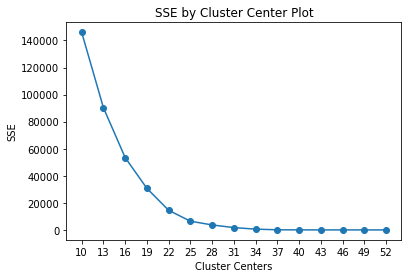

In [112]:
def find_optimal_clusters(data, max_k):
    iters = range(10, max_k, 3)
    
    sse = []
    for k in iters:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=42)    
        kmeans_model.fit(data)
        val = kmeans_model.inertia_
        sse.append(val)
        #labels = kmeans_model.labels_
        #print(metrics.silhouette_score(data, labels, metric='euclidean'))
        print('Fit {} clusters. SSE {}'.format(k,val))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 55)

In [132]:
true_k = 26

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 indentation
 unexpected indentation
 unexpected
 variable val
 line detected
 functionality holds
 functionality holds data
 holds
 holds data
 increase
Cluster 1:
 missing spacing
 spacing
 missing
 variable val
 line detected
 functionality holds data
 holds
 holds data
 increase
 increase readability
Cluster 2:
 expression contains magic
 expression contains
 contains magic
 contains magic number
 magic number
 magic
 number
 contains
 expression
 variable val
Cluster 3:
 unnecessary replaced
 replaced
 parentheses unnecessary replaced
 parentheses unnecessary
 parentheses
 unnecessary
 functionality holds
 functionality
 length code
 functionality holds data
Cluster 4:
 variable val
 val
 variable
 line detected
 functionality holds
 functionality holds data
 holds
 holds data
 increase
 increase readability
Cluster 5:
 unexpected spacing
 unexpected
 spacing
 variable val
 line detected
 functionality holds
 functionality holds data
 holds
 holds

In [133]:
df_style['reason_3'] = model.predict(vectorizer.transform(df_style['message']))
df_style

,user_id,sub_id,language,code,quality,type,text,code_part,string,symbol,difficulty,message,reason,reason_3
0,3571,160182,kotlin,"fun main() {\n println(""Hello, World!"")\n}",GOOD,Indentation,Unexpected indentation (3) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,0
1,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,0
2,3581,193594,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation,2,0
3,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),fun main() {,0,12,,Unexpected indentation,2,0
4,3581,193659,kotlin,"fun main() {\n val text = ""Hello, World!""\...",MODERATE,Indentation,Unexpected indentation (5) (it should be 4),"val text = ""Hello, World!""",1,31,,Unexpected indentation,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976534,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return false,8,0,EASY,Unexpected indentation,2,0
976535,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (9) (should be 8),} else {,9,0,EASY,Unexpected indentation,2,0
976536,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),balance -= amount,10,0,EASY,Unexpected indentation,2,0
976537,7805,29085194,kotlin,class Account {\n\n var balance = 0L\n\n ...,BAD,Indentation,Unexpected indentation (13) (should be 12),return true,11,0,EASY,Unexpected indentation,2,0


In [138]:
r = df_style.groupby('reason_3')['message'].count().sort_values(ascending = False)
r

reason_3
1     228017
2     210831
0     186308
5      49498
4      39268
3      37268
9      28656
10     19949
7      18393
11     18050
14     17216
6      15668
8      14058
12     12664
15     12373
19     11409
16     11341
13      9083
17      9004
21      5993
18      5778
20      4438
22      3871
23      3418
24      2532
25      1455
Name: message, dtype: int64

In [149]:
list(r)

[228017,
 210831,
 186308,
 49498,
 39268,
 37268,
 28656,
 19949,
 18393,
 18050,
 17216,
 15668,
 14058,
 12664,
 12373,
 11409,
 11341,
 9083,
 9004,
 5993,
 5778,
 4438,
 3871,
 3418,
 2532,
 1455]

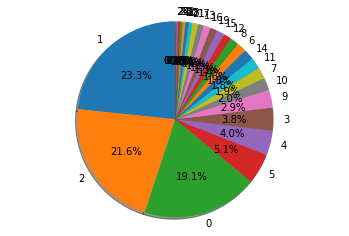

In [151]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(r.keys())
sizes = list(r)
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [123]:
pd.unique(df_style[df_style['reason_3']==3]['message'])

array(['Parentheses in are unnecessary and can be replaced with',
       "Parentheses in (!firstNumber && input[i]=='-') are unnecessary and can be replaced with",
       "Parentheses in (cardNumber[] != ' ' && cardNumber[] != ' ' && cardNumber[] != ' ') are unnecessary and can be replaced with",
       "Parentheses in (input[i] != ' ') are unnecessary and can be replaced with",
       "Parentheses in (cardNumber[] == ' ') are unnecessary and can be replaced with",
       "Parentheses in && cardNumber[i] == ' ') are unnecessary and can be replaced with",
       "Parentheses in ('+') are unnecessary and can be replaced with"],
      dtype=object)

In [120]:
pd.unique(df_style[df_style['reason_3']==2]['text'])

array(['Unexpected indentation (3) (it should be 4)',
       'Unexpected indentation (5) (it should be 4)',
       'Unexpected indentation (2) (it should be 4)',
       'Unexpected indentation (1) (it should be 4)',
       'Unexpected indentation (11) (it should be 4)',
       'Unexpected indentation (3) (it should be 5)',
       'Unexpected indentation (4) (it should be 7)',
       'Unexpected indentation (7) (it should be 4)',
       'Unexpected indentation (6) (it should be 4)',
       'Unexpected indentation (4) (it should be 5)',
       'Unexpected indentation (9) (it should be 4)',
       'Unexpected indentation (6) (it should be 8)',
       'Unexpected indentation (5) (it should be 8)',
       'Unexpected indentation (7) (it should be 8)',
       'Unexpected indentation (8) (it should be 6)',
       'Unexpected indentation (8) (it should be 7)',
       'Unexpected indentation (11) (it should be 12)',
       'Unexpected indentation (10) (it should be 4)',
       'Unexpected inden

In [136]:
pd.unique(df_style[df_style['reason']==10]['text'])

array(['Using the forEach method on ranges has a heavy performance cost. Prefer using simple for loops.',
       'This empty block of code can be removed.',
       "The import 'kotlin.concurrent.thread' is unused.",
       'Unexpected space after "}"',
       "The import 'kotlin.math.round' is unused.",
       "The import 'kotlin.math.abs' is unused.",
       "The import 'java.util.Scanner' is unused.",
       'Imports must be ordered in lexicographic order without any empty lines in-between',
       'java.lang.Math.* is a wildcard import. Replace it with fully qualified imports.',
       "The import 'kotlin.math.roundToInt' is unused.",
       "The import 'java.lang.StrictMath.abs' is unused.",
       'kotlin.math.* is a wildcard import. Replace it with fully qualified imports.',
       'let expression can be omitted',
       'Function main is nested too deeply.',
       "The import 'kotlin.math.ceil' is unused.",
       "The import 'kotlin.collections.ArrayList' is unused.",
       "

In [137]:
pd.unique(df_style[df_style['reason_3']==6]['text'])

array(['Using the forEach method on ranges has a heavy performance cost. Prefer using simple for loops.',
       'This empty block of code can be removed.',
       "The import 'kotlin.concurrent.thread' is unused.",
       'Unexpected space after "}"',
       "The import 'kotlin.math.round' is unused.",
       "The import 'kotlin.math.abs' is unused.",
       "The import 'java.util.Scanner' is unused.",
       'Imports must be ordered in lexicographic order without any empty lines in-between',
       'java.lang.Math.* is a wildcard import. Replace it with fully qualified imports.',
       "The import 'kotlin.math.roundToInt' is unused.",
       "The import 'java.lang.StrictMath.abs' is unused.",
       'kotlin.math.* is a wildcard import. Replace it with fully qualified imports.',
       'let expression can be omitted',
       'Function main is nested too deeply.',
       "The import 'kotlin.math.ceil' is unused.",
       "The import 'kotlin.collections.ArrayList' is unused.",
       "

In [127]:
pd.unique(df_style[df_style['reason']==14]['text'])

array(['Using the forEach method on ranges has a heavy performance cost. Prefer using simple for loops.',
       'This empty block of code can be removed.',
       "The import 'kotlin.concurrent.thread' is unused.",
       "The import 'kotlin.math.round' is unused.",
       "The import 'kotlin.math.abs' is unused.",
       "The import 'java.util.Scanner' is unused.",
       'Imports must be ordered in lexicographic order without any empty lines in-between',
       'java.lang.Math.* is a wildcard import. Replace it with fully qualified imports.',
       "The import 'kotlin.math.roundToInt' is unused.",
       "The import 'java.lang.StrictMath.abs' is unused.",
       'kotlin.math.* is a wildcard import. Replace it with fully qualified imports.',
       'let expression can be omitted',
       'Function main is nested too deeply.',
       "The import 'kotlin.math.ceil' is unused.",
       "The import 'kotlin.collections.ArrayList' is unused.",
       "The import 'java.lang.Math.PI' is unu

In [95]:
classter_name = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    name = ""
    for ind in order_centroids[i, :5]:
        name += terms[ind] + " "
    classter_name[i] = name.strip()    
classter_name   

{0: 'match match pattern names match pattern names match pattern',
 1: 'missing spacing spacing missing variable val line detected',
 2: 'expression contains magic expression contains contains magic contains magic number magic number',
 3: 'indentation unexpected indentation unexpected variable val line detected',
 4: 'detected class expression literal order',
 5: 'variable val val variable line detected functionality holds',
 6: 'unexpected spacing unexpected spacing variable val line detected',
 7: 'semicolon unnecessary semicolon unnecessary variable val line detected',
 8: 'unnecessary replaced replaced parentheses unnecessary replaced parentheses unnecessary parentheses',
 9: 'needless blank blank line needless blank line needless blank',
 10: 'missing space missing space // space // // space',
 11: 'holds defines functionality functionality holds data functionality holds functionality',
 12: 'does braces does multi-line braces statement does',
 13: 'missing newline newline missin

In [135]:
df_style.pivot_table(values='sub_id', index = 'reason', \
                     columns= 'reason_3', aggfunc= 'count', fill_value=0)

reason_3,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
reason,,,,,,,,,,,,,,,,,,,,,
0,0,0,210831,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,228017,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,186308,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,28656,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,39268,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,49498,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,37268,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    min_count=10,
    window=2,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [34]:
import spacy  # For preprocessing

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [36]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_res['reason'])

In [40]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]


In [41]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1848, 1)

In [43]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']]


In [46]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

bigram = Phraser(phrases)

In [47]:
sentences = bigram[sent]

In [49]:
from collections import defaultdict 

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

1014

In [50]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

["'",
 'function',
 'type',
 'expect',
 'argument',
 'invocation',
 'public',
 'fun',
 'operator_correspond',
 'dot_qualified']

In [51]:
import multiprocessing

from gensim.models import Word2Vec

In [53]:
cores = multiprocessing.cpu_count()
cores

4

In [ ]:
from gensim.models.phrases import Phrases, Phraser
import spacy  # For preprocessing

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_res['reason'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=3)
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)


In [55]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [56]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [57]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(13995, 314640)

In [58]:
w2v_model.init_sims(replace=True)


<ipython-input-58-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [89]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    vocab = w2v_model.wv.key_to_index.keys()
    
    for word in vocab:
        tokens.append(w2v_model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(w2v_model)

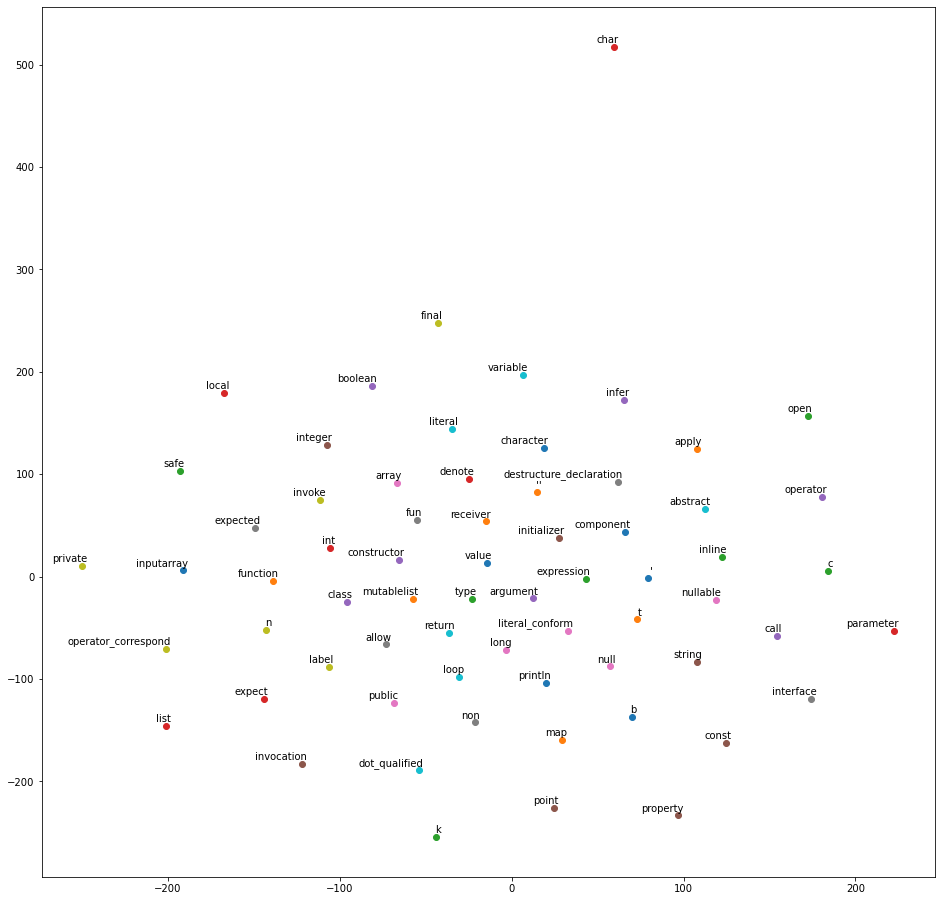

In [90]:
tsne_plot(w2v_model)


In [60]:
model = w2v_model
w2v_vectors = model.wv.vectors # here you load vectors for each word in your model
w2v_indices = model.wv.key_to_index # here you load indices - with whom you can find an index of the particular word in your model 

In [91]:
vocab = w2v_model.wv.key_to_index.keys()
vocab

dict_keys(["'", 'function', 'type', 'expect', 'argument', 'invocation', 'public', 'fun', 'operator_correspond', 'dot_qualified', 'character', "''", 'expression', 'int', 'constructor', 'string', 'literal_conform', 'expected', 'invoke', 'literal', 'value', 't', 'inline', 'parameter', 'operator', 'integer', 'array', 'allow', 'final', 'return', 'println', 'apply', 'safe', 'list', 'class', 'initializer', 'null', 'destructure_declaration', 'n', 'loop', 'component', 'mutablelist', 'open', 'char', 'boolean', 'property', 'long', 'non', 'private', 'abstract', 'b', 'receiver', 'k', 'local', 'call', 'point', 'nullable', 'interface', 'label', 'variable', 'inputarray', 'map', 'c', 'denote', 'infer', 'const'])

In [96]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/.]{2,})', ngram_range = {1,3})
X = vectorizer.fit_transform(pd.unique(df_res['reason']))

vectorizer.get_feature_names()

['//',
 'abstract',
 'abstract fun',
 'abstract operator',
 'abstract operator fun',
 'allowed',
 'allowed nullable',
 'allowed nullable receiver',
 'applied',
 'applied list',
 'argument',
 'argument expected',
 'arguments',
 'arguments expected',
 'arguments expected constructor',
 'arguments local',
 'arguments local final',
 'arguments private',
 'arguments private constructor',
 'arguments public',
 'arguments public abstract',
 'arguments public constructor',
 'arguments public final',
 'arguments public fun',
 'arguments public inline',
 'arguments public open',
 'array',
 'boolean',
 'boolean literal',
 'boolean literal does',
 'box',
 'char',
 'character',
 'character literal',
 'character literal does',
 'characters',
 'characters character',
 'characters character literal',
 'class',
 'code',
 'component',
 'component function',
 'conform',
 'conform expected',
 'conform expected type',
 'const',
 'const type',
 'constructor',
 'corresponds',
 'corresponds dot-qualified',
 '

In [97]:
vectorizer = TfidfVectorizer(min_df = 0.005,  stop_words ='english', token_pattern= r'([a-zA-Z-/.]{2,})', ngram_range = {1,3})
X = vectorizer.fit_transform(pd.unique(df_res['reason']))

vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X)
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

<2602x195 sparse matrix of type '<class 'numpy.float64'>'
	with 16356 stored elements in Compressed Sparse Row format>

In [98]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

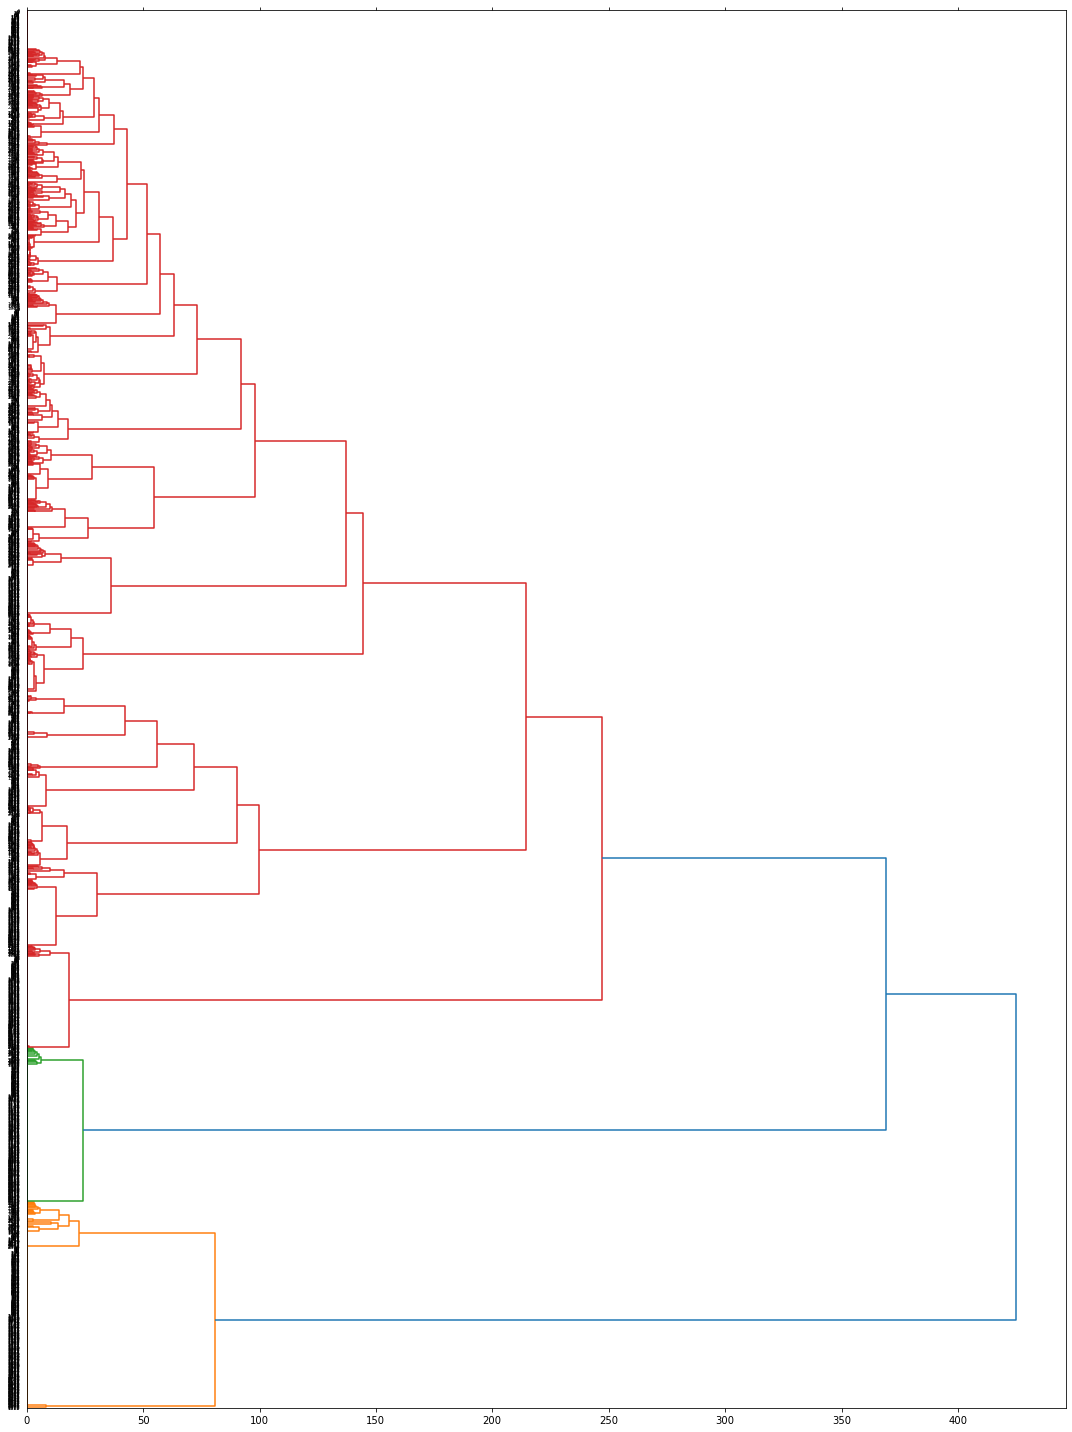

In [100]:

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters